# FCIQMC (Full Configuration Interaction Quantum Monte Carlo)

論文 [Fermion Monte Carlo without fixed nodes: A game of life, death, and
annihilation in Slater determinant space](https://2024.sci-hub.st/1534/f26924b07d1005f6f9a7be1b525feec7/booth2009.pdf) を読み、Pythonでの実装を試みる。

## 準備

```
$ conda install tqdm pandas
$ conda install -c conda-forge pyscf
```

## 共通の関数を定義

In [11]:
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from pyscf import gto, scf, fci, ao2mo
import random

rng = np.random.default_rng()

def build_hamiltonian(mol):
    elec_num = sum(mol.nelec)
    myhf = mol.HF()
    myhf.kernel()
    mymp2 = myhf.MP2()
    mymp2.kernel() # run mp2
    C = myhf.mo_coeff # molecular coefficient matrix
    h1 = np.matmul((C.T),np.matmul((myhf.get_hcore()),(C)))
    h2 = ao2mo.kernel(mol,C)
    h2 = ao2mo.restore(8,h2,mol.nao_nr())

    H_mat = fci.direct_spin1.pspace(h1, h2, mol.nao_nr(), elec_num, np=70000)[1] # creates Hamiltonian
    nspatorbs = int(mol.nao_nr())

    # --- フル FCI エネルギー ---
    cis = fci.FCI(myhf)
    E_fci, civec = cis.kernel(h1, h2, C.shape[1], mol.nelec)
    E_HF = myhf.e_tot

    return H_mat, E_fci, E_HF

# mol = gto.M(atom='H 0 0 0; H 0 0 0.74', basis='sto-3g', verbose=0)
# H_mat, E_fci, E_HF = build_hamiltonian(mol)
# print(H_mat)


def FCIQMC(mol, shift=0, init_n_walker=1, n_steps=5000, step_starting_shift_upd=500, n_prod=2500,
           shift_upd_interval=10, dt=0.001, damping=0.05):
    """
    Full Configuration Interaction Quantum Monte Carlo (FCIQMC) を用いて基底状態エネルギーを推定する。

    Args:
        mol: PySCFのMoleculeオブジェクト
        shift: 初期シフト値 S(0)。ウォーカー数の増減を抑制するためのエネルギー的バイアス
        init_n_walker: 初期状態（参照決定基）に配置するウォーカー数
        n_steps: シミュレーションの総ステップ数
        step_starting_shift_upd: Shift の更新を開始するステップ。初期緩和期間としてこのステップまでは shift を固定する。
        shift_upd_interval: Shift をどの頻度で更新するか（ステップ単位）。例えば 10 なら、10 ステップごとに shift を更新する。
        n_prod: E_projの平均を計算するステップ数（処理完了時からこのステップ数遡って平均を取る）
        dt: imaginary time step（時間刻み）。小さいほど安定するが計算コストが増える
        damping: Shift更新時の更新の程度表すパラメータ
        

    Returns:
        tuple:
            - **E_est (float)**: 最終 1000 ステップの projected energy の平均（推定エネルギー）
            - **hist_population (list[int])**: 各ステップのウォーカー総数の履歴
            - **hist_shift (list[float])**: 各ステップの shift の履歴
            - **hist_energy (list[float])**: 各ステップの projected energy の履歴
    """    
    H_mat, E_fci, E_HF = build_hamiltonian(mol)
    print(f"--- FCI Matrix ---")
    print(H_mat.shape)
    print(H_mat)

    H_mat = H_mat - np.eye(H_mat.shape[0]) * E_HF
    print(f"--- K Matrix ---")
    print(H_mat)
    
    E_est = 0
    hist_population, hist_shift, hist_energy = [], [], []
    
    diag_H = np.diag(H_mat)    
    pre_shift = shift
    pre_pop = init_n_walker

    # 基底状態（Hartree-Fock解）のインデックスを特定
    # PySCFのFCIでは通常、最初の行列要素がHF状態に対応します
    ref_det_idx = 0 
        
    # ウォーカーの初期化 {det_index: signed_population}
    # 符号付き整数で管理（+1, -1など）
    walkers = {ref_det_idx: init_n_walker}

    print('\n---- Initial walkers ----')
    for k, v in walkers.items():
        tqdm.write(f"{v} walkers on {k}th determinant")

    
    for step in tqdm(range(n_steps)):
        new_walkers = defaultdict(int)
        
        # walkersが乗っている行列式の全てのインデックスを取得
        current_dets = list(walkers.keys())
        # if step % 1000 == 0:
        #     tqdm.write(f"current_dets: {current_dets}")

        
        for i in current_dets:
            n_i = walkers[i] # ith行列式上のウォーカー数（符号付き）
            if n_i == 0: continue

            # ----- Spawning Step -----
            # 通常は接続された決定基をランダムサンプリングするが、
            # ここでは行列が小さいため、接続している全 j を走査（簡単のため）
            row = H_mat[i]
            # 非ゼロ要素のインデックスを取得
            connected_dets = np.where(row != 0)[0]
            
            for j in connected_dets:
                # 対角要素は自分自身への遷移を表すので処理しない
                if i == j: continue
                h_ij = row[j]

                # Spawning probability: Ps = dt * |H_ij|
                # 生成される数: sign(walker) * sign(-H_ij)
                # 論文では分母にp_gen(j|i)がくるが、今回の実装では、i -> jは全て走査されるため1としている
                # もし励起の1つをランダムに選ぶ実装の場合は、1/N_exciteに置き換える必要がある
                # 系が大きくなると全走査が難しくなるので、必要なら実装を修正すること
                prob_spawn = dt * abs(h_ij)

                # 全てのwalkerに対して、spawnを試みる
                n_spawn = np.full(abs(n_i), 0)
                prob_spawn_frac, prob_spawn_int = math.modf(prob_spawn)
                if prob_spawn_int > 1:
                    n_spawn = np.full(abs(n_i), prob_spawn_int)
                n_spawn += (np.random.rand(abs(n_i)) <= prob_spawn).astype(int)
                
                # h_ij>0ならば親と異符号、h_ij<0ならば親と同符号のwalkerを遷移先jth行列式の上に生成
                if h_ij > 0:
                    new_walkers[j] += -np.sign(n_i) * np.sum(n_spawn)
                else:
                    new_walkers[j] += np.sign(n_i) * np.sum(n_spawn)


            # ----- Diagonal Step (Death/Cloning) -----
            # Pd = exp(-dt * (H_ii - S)) - 1  ~ -dt * (H_ii - S)
            h_ii = diag_H[i]
            prob_death = dt * (h_ii - shift)
            n_walker_on_D = n_i
            sign = np.sign(n_walker_on_D)

            # prob_deathの確率でdeath/cloneする（対象となるwalkerの数をカウントする）
            count = np.sum(np.random.rand(abs(n_i)) <= abs(prob_death))
            if prob_death > 0:
                # prob_deathが正ならwalkerをcount分消滅させる
                n_walker_on_D = sign * (abs(n_walker_on_D) - count)
            else:
                # prob_deathが負ならwalkerをcount分複製する
                n_walker_on_D = sign * (abs(n_walker_on_D) + count)    
            walkers[i] = n_walker_on_D
            

        # ----- Annihilation Step -----
        for idx, n in new_walkers.items():
            walkers[idx] = walkers.get(idx, 0) + n

        # ---- Shift Update -----
        current_pop = sum(abs(w) for w in walkers.values())
        if step > step_starting_shift_upd: # 初期緩和後
            if step % shift_upd_interval == 0:
                shift = pre_shift - (damping / (shift_upd_interval*dt)) * np.log(current_pop / pre_pop)
                pre_shift = shift
        hist_shift.append(shift)
        pre_pop = current_pop
        hist_population.append(current_pop)
        
        # ----- Energy Estimation (Projected Energy) -----
        # E_HF2 = diag_H[ref_det_idx]  # これはE_HFではない
        row0 = H_mat[ref_det_idx]
        num_ref = walkers.get(ref_det_idx, 0)

        # 論文では、singles/doublesに限定して合計している
        # この実装だとそもそもFCI行列の成分がsingles/doubles以外が0になっているので、
        # 全部を合計していて、結局singles/doublesだけが合計されることになっている
        E_proj = E_HF + sum(row0[idx]*v/num_ref for idx, v in walkers.items() if idx != ref_det_idx)
        
        # 生成したコードでは論文にはない項を足していた
        # これはハミルトニアンに各反発エネルギーが含まれているかいないかの解釈が論文と異なっているため？
        # これを含めなければ近い値に収束するので、コメントアウトしておく
        # E_proj += mol.energy_nuc()
        hist_energy.append(E_proj)
        
        if step % 1000 == 0:
            tqdm.write(f"Step {step}: Walkers={current_pop}, Shift={shift:.5f}, E_proj={E_proj:.6f}")
            for k, v in walkers.items():
                if v != 0:
                    tqdm.write(f"  {v} walkers on {k}th determinant")

    E_est = np.mean(hist_energy[-n_prod:]) # 最後の1000ステップの平均
    
    print('\n---- Walkers (result) ----')
    for k, v in walkers.items():
        if v != 0:
            print(f"{v} walkers on {k}th determinant")

    return E_est, E_fci, E_HF, hist_population, hist_shift, hist_energy


def plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy):
    plt.figure(figsize=(10, 6))
    plt.plot(hist_population)
    plt.xlabel('Step')
    plt.ylabel('Population')
    plt.yscale('log')

    E_corr = np.full_like(hist_shift, E_fci - E_HF)
    plt.figure(figsize=(10, 6))
    plt.plot(hist_shift, label="Shift")
    plt.plot(E_corr, linestyle="--", label=r"${E_{corr}}$")
    plt.xlabel('Step')
    plt.ylabel('Shift')
    plt.legend()

    E_fci_arr = np.full_like(hist_energy, E_fci)
    plt.figure(figsize=(10, 6))
    plt.plot(hist_energy, label=r"${E_{proj}}$")
    plt.plot(E_fci_arr, linestyle="--", label=r"${E_{FCI}}$")
    plt.xlabel('Step')
    plt.ylabel('Projected Energy')
    plt.legend()
    
    plt.show()

## ${H_2}$ 分子 STO-3G

FCIによる基底エネルギーは -1.1373 で、FCIQMCによる推定基底エネルギーは近い値が出るが、Shiftが下がり続け、${E_{corr}}$の値に収束しない（原因不明）。

--- FCI Matrix ---
(4, 4)
[[-1.83186365e+00 -3.63850793e-16 -3.63850793e-16  1.81210462e-01]
 [-3.63850793e-16 -1.06466723e+00  1.81210462e-01  1.90003444e-16]
 [-3.63850793e-16  1.81210462e-01 -1.06466723e+00  1.90003444e-16]
 [ 1.81210462e-01  1.90003444e-16  1.90003444e-16 -2.52486193e-01]]
--- K Matrix ---
[[-7.15104339e-01 -3.63850793e-16 -3.63850793e-16  1.81210462e-01]
 [-3.63850793e-16  5.20920733e-02  1.81210462e-01  1.90003444e-16]
 [-3.63850793e-16  1.81210462e-01  5.20920733e-02  1.90003444e-16]
 [ 1.81210462e-01  1.90003444e-16  1.90003444e-16  8.64273114e-01]]

---- Initial walkers ----
10 walkers on 0th determinant


  7%|██████▋                                                                                   | 1489/20000 [00:00<00:01, 14885.54it/s]

Step 0: Walkers=10, Shift=0.00000, E_proj=-1.116759
  10 walkers on 0th determinant
Step 1000: Walkers=20, Shift=0.00000, E_proj=-1.126297
  19 walkers on 0th determinant
  -1 walkers on 3th determinant
Step 2000: Walkers=43, Shift=0.00000, E_proj=-1.135345
  39 walkers on 0th determinant
  -4 walkers on 3th determinant
Step 3000: Walkers=90, Shift=0.00000, E_proj=-1.134438
  82 walkers on 0th determinant
  -8 walkers on 3th determinant


 34%|██████████████████████████████▏                                                           | 6721/20000 [00:00<00:00, 16600.97it/s]

Step 4000: Walkers=218, Shift=0.00000, E_proj=-1.135063
  198 walkers on 0th determinant
  -20 walkers on 3th determinant
Step 5000: Walkers=423, Shift=0.00000, E_proj=-1.136209
  382 walkers on 0th determinant
  -41 walkers on 3th determinant
Step 6000: Walkers=858, Shift=0.00000, E_proj=-1.135908
  776 walkers on 0th determinant
  -82 walkers on 3th determinant
Step 7000: Walkers=1806, Shift=0.00000, E_proj=-1.137440
  1621 walkers on 0th determinant
  -185 walkers on 3th determinant


 42%|█████████████████████████████████████▋                                                    | 8383/20000 [00:00<00:00, 13045.61it/s]

Step 8000: Walkers=3669, Shift=0.00000, E_proj=-1.135748
  3321 walkers on 0th determinant
  -348 walkers on 3th determinant
Step 9000: Walkers=7760, Shift=0.00000, E_proj=-1.135776
  7023 walkers on 0th determinant
  -737 walkers on 3th determinant


 49%|████████████████████████████████████████████▌                                              | 9785/20000 [00:00<00:01, 8747.30it/s]

Step 10000: Walkers=16326, Shift=0.00000, E_proj=-1.137449
  14653 walkers on 0th determinant
  -1673 walkers on 3th determinant


 54%|████████████████████████████████████████████████▉                                         | 10878/20000 [00:01<00:01, 5264.64it/s]

Step 11000: Walkers=29140, Shift=-0.29115, E_proj=-1.137448
  26154 walkers on 0th determinant
  -2986 walkers on 3th determinant


 58%|████████████████████████████████████████████████████▌                                     | 11693/20000 [00:02<00:02, 3492.46it/s]

Step 12000: Walkers=41360, Shift=-0.47336, E_proj=-1.136899
  37223 walkers on 0th determinant
  -4137 walkers on 3th determinant


 66%|██████████████████████████████████████████████████████████▉                               | 13103/20000 [00:03<00:03, 1857.09it/s]

Step 13000: Walkers=51075, Shift=-0.57487, E_proj=-1.137498
  45830 walkers on 0th determinant
  -5245 walkers on 3th determinant


 70%|███████████████████████████████████████████████████████████████▎                          | 14077/20000 [00:04<00:05, 1179.45it/s]

Step 14000: Walkers=57907, Shift=-0.63715, E_proj=-1.137228
  52030 walkers on 0th determinant
  -5877 walkers on 3th determinant


 76%|████████████████████████████████████████████████████████████████████▉                      | 15144/20000 [00:05<00:05, 838.38it/s]

Step 15000: Walkers=62516, Shift=-0.67261, E_proj=-1.137193
  56181 walkers on 0th determinant
  -6335 walkers on 3th determinant


 81%|█████████████████████████████████████████████████████████████████████████▎                 | 16111/20000 [00:06<00:05, 771.57it/s]

Step 16000: Walkers=65496, Shift=-0.70226, E_proj=-1.137131
  58877 walkers on 0th determinant
  -6619 walkers on 3th determinant


 86%|██████████████████████████████████████████████████████████████████████████████             | 17148/20000 [00:07<00:03, 776.51it/s]

Step 17000: Walkers=67265, Shift=-0.71987, E_proj=-1.137563
  60338 walkers on 0th determinant
  -6927 walkers on 3th determinant


 91%|██████████████████████████████████████████████████████████████████████████████████▎        | 18104/20000 [00:09<00:02, 771.94it/s]

Step 18000: Walkers=68225, Shift=-0.72260, E_proj=-1.137194
  61311 walkers on 0th determinant
  -6914 walkers on 3th determinant


 96%|███████████████████████████████████████████████████████████████████████████████████████    | 19121/20000 [00:10<00:01, 765.30it/s]

Step 19000: Walkers=68780, Shift=-0.72741, E_proj=-1.136868
  61910 walkers on 0th determinant
  -6870 walkers on 3th determinant


100%|██████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:11<00:00, 1713.69it/s]



---- Walkers (result) ----
62436 walkers on 0th determinant
-6999 walkers on 3th determinant
E_fci=-1.137283834488502, E_HF=-1.1167593073964248
------------------------------
FCI Energy: -1.137284 Ha
Final FCIQMC Energy: -1.137161 Ha


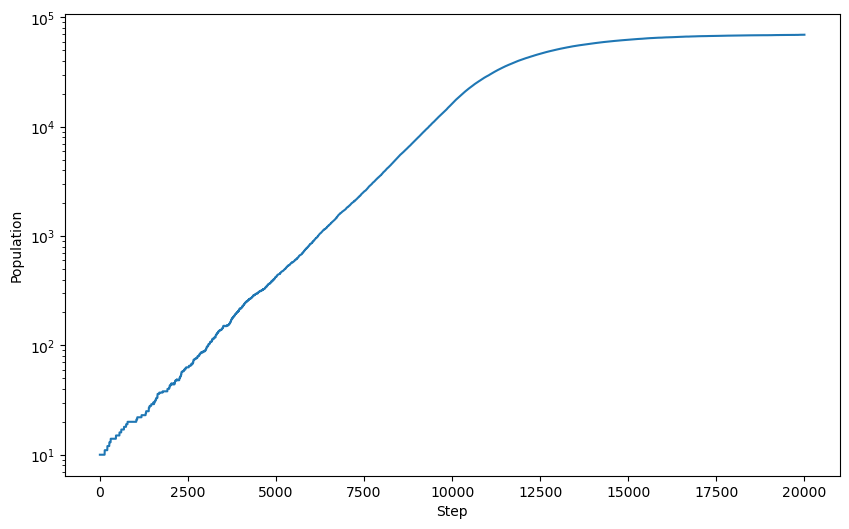

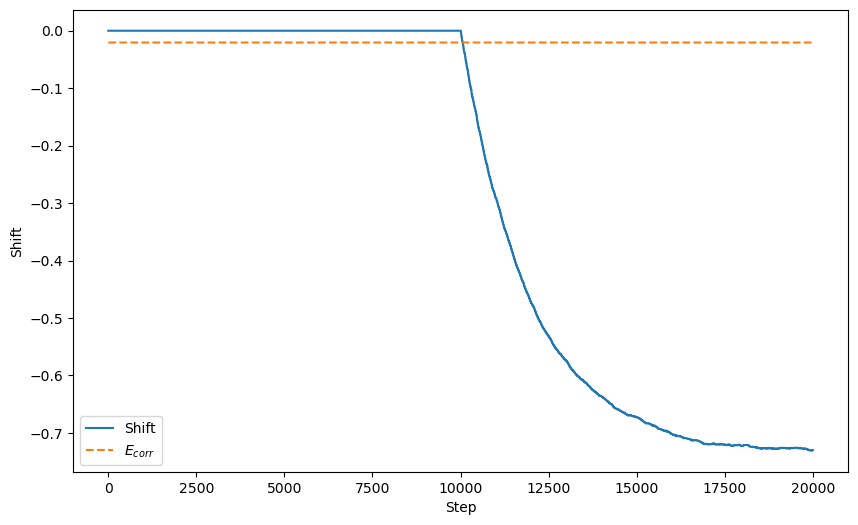

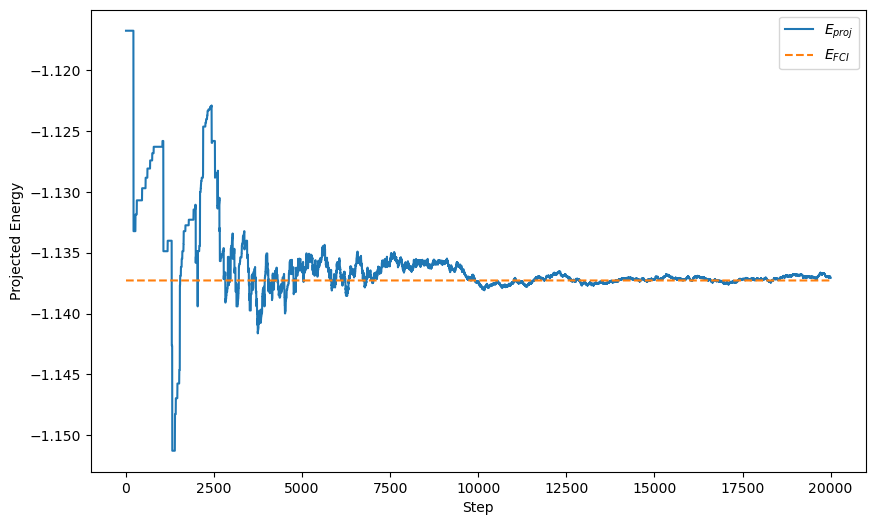

In [12]:
from pyscf import gto

# H2分子の定義 (0.74 Angstrom)
mol = gto.M(atom='H 0 0 0; H 0 0 0.74', basis='sto-3g', verbose=0)
E_est, E_fci, E_HF, hist_population, hist_shift, hist_energy = \
    FCIQMC(mol, init_n_walker=10, n_steps=20000, n_prod=8000, step_starting_shift_upd=10000)

print(f"E_fci={E_fci}, E_HF={E_HF}")

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"Final FCIQMC Energy: {E_est:.6f} Ha")
plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy)


## ${H_3^+}$ (sto-3g)
FCI行列は9x9

converged SCF energy = -1.24591513197544
E(RMP2) = -1.26559786762945  E_corr = -0.0196827356540126
E(SCS-RMP2) = -1.26953441476026  E_corr = -0.0236192827848151
--- FCI Matrix ---
(9, 9)
[[-2.83347005e+00  2.78282448e-17 -9.82897130e-09  2.78282448e-17
   1.44076448e-01 -4.65022949e-17 -9.82897130e-09 -4.65022949e-17
   1.44076569e-01]
 [ 2.78282448e-17 -2.20370352e+00 -4.94150488e-17  1.44076448e-01
   2.23904423e-12 -9.56437226e-02 -4.65022949e-17 -9.56440818e-02
  -2.23896578e-12]
 [-9.82897130e-09 -4.94150488e-17 -2.20368581e+00 -4.65022949e-17
  -9.56437226e-02 -2.23892764e-12  1.44076569e-01 -2.23896578e-12
   9.56396165e-02]
 [ 2.78282448e-17  1.44076448e-01 -4.65022949e-17 -2.20370352e+00
   2.23904423e-12 -9.56440818e-02 -4.94150488e-17 -9.56437226e-02
  -2.23896578e-12]
 [ 1.44076448e-01  2.23904423e-12 -9.56437226e-02  2.23904423e-12
  -1.47385244e+00 -3.38168990e-16 -9.56437226e-02 -3.38168990e-16
   7.58871399e-02]
 [-4.65022949e-17 -9.56437226e-02 -2.23892764e-12 -9.56440

 10%|████████▌                                                                                 | 1429/15000 [00:00<00:00, 14279.02it/s]

Step 0: Walkers=1, Shift=0.00000, E_proj=-1.245915
  1 walkers on 0th determinant
Step 1000: Walkers=3, Shift=0.00000, E_proj=-1.245915
  3 walkers on 0th determinant


 10%|████████▌                                                                                 | 1429/15000 [00:00<00:00, 14279.02it/s]

Step 2000: Walkers=20, Shift=0.00000, E_proj=-1.262865
  17 walkers on 0th determinant
  -1 walkers on 4th determinant
  -1 walkers on 6th determinant
  -1 walkers on 8th determinant


 25%|██████████████████████▌                                                                    | 3719/15000 [00:00<00:02, 5318.50it/s]

Step 3000: Walkers=133, Shift=0.00000, E_proj=-1.282641
  102 walkers on 0th determinant
  1 walkers on 2th determinant
  -12 walkers on 4th determinant
  -4 walkers on 6th determinant
  -14 walkers on 8th determinant


 29%|██████████████████████████▍                                                                | 4368/15000 [00:00<00:02, 4737.35it/s]

Step 4000: Walkers=647, Shift=0.00000, E_proj=-1.275116
  523 walkers on 0th determinant
  11 walkers on 2th determinant
  -46 walkers on 4th determinant
  -7 walkers on 6th determinant
  -60 walkers on 8th determinant


 36%|████████████████████████████████▌                                                          | 5370/15000 [00:01<00:02, 3820.42it/s]

Step 5000: Walkers=2358, Shift=-0.61609, E_proj=-1.273765
  1940 walkers on 0th determinant
  24 walkers on 2th determinant
  -188 walkers on 4th determinant
  -19 walkers on 6th determinant
  -187 walkers on 8th determinant


 41%|█████████████████████████████████████▏                                                     | 6122/15000 [00:01<00:02, 3036.48it/s]

Step 6000: Walkers=5315, Shift=-0.97752, E_proj=-1.273440
  4423 walkers on 0th determinant
  28 walkers on 2th determinant
  -427 walkers on 4th determinant
  -19 walkers on 6th determinant
  -418 walkers on 8th determinant


 48%|███████████████████████████████████████████▌                                               | 7185/15000 [00:02<00:03, 2096.38it/s]

Step 7000: Walkers=8745, Shift=-1.22280, E_proj=-1.273271
  7305 walkers on 0th determinant
  10 walkers on 2th determinant
  -731 walkers on 4th determinant
  -43 walkers on 6th determinant
  -656 walkers on 8th determinant


 54%|█████████████████████████████████████████████████                                          | 8091/15000 [00:02<00:04, 1460.26it/s]

Step 8000: Walkers=12052, Shift=-1.36879, E_proj=-1.273991
  10058 walkers on 0th determinant
  4 walkers on 2th determinant
  -978 walkers on 4th determinant
  -30 walkers on 6th determinant
  -982 walkers on 8th determinant


 61%|███████████████████████████████████████████████████████▋                                   | 9178/15000 [00:03<00:04, 1224.47it/s]

Step 9000: Walkers=14714, Shift=-1.46441, E_proj=-1.273864
  12274 walkers on 0th determinant
  8 walkers on 2th determinant
  -1186 walkers on 4th determinant
  -51 walkers on 6th determinant
  -1195 walkers on 8th determinant


 67%|████████████████████████████████████████████████████████████▋                             | 10119/15000 [00:04<00:04, 1115.78it/s]

Step 10000: Walkers=16471, Shift=-1.53012, E_proj=-1.274034
  13727 walkers on 0th determinant
  32 walkers on 2th determinant
  -1379 walkers on 4th determinant
  -33 walkers on 6th determinant
  -1300 walkers on 8th determinant


 74%|██████████████████████████████████████████████████████████████████▌                       | 11100/15000 [00:05<00:03, 1047.71it/s]

Step 11000: Walkers=17564, Shift=-1.56970, E_proj=-1.274400
  14633 walkers on 0th determinant
  14 walkers on 2th determinant
  -1457 walkers on 4th determinant
  -24 walkers on 6th determinant
  -1436 walkers on 8th determinant


 81%|████████████████████████████████████████████████████████████████████████▉                 | 12147/15000 [00:06<00:02, 1002.77it/s]

Step 12000: Walkers=18180, Shift=-1.59077, E_proj=-1.273688
  15231 walkers on 0th determinant
  5 walkers on 2th determinant
  -1465 walkers on 4th determinant
  -8 walkers on 6th determinant
  -1471 walkers on 8th determinant


 88%|███████████████████████████████████████████████████████████████████████████████▊           | 13155/15000 [00:07<00:01, 980.23it/s]

Step 13000: Walkers=18538, Shift=-1.59734, E_proj=-1.273766
  15509 walkers on 0th determinant
  8 walkers on 2th determinant
  -1524 walkers on 4th determinant
  -23 walkers on 6th determinant
  -1474 walkers on 8th determinant


 94%|█████████████████████████████████████████████████████████████████████████████████████▉     | 14160/15000 [00:08<00:00, 988.24it/s]

Step 14000: Walkers=18900, Shift=-1.59070, E_proj=-1.273705
  15823 walkers on 0th determinant
  5 walkers on 2th determinant
  -1561 walkers on 4th determinant
  -20 walkers on 6th determinant
  -1491 walkers on 8th determinant


100%|██████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [00:09<00:00, 1621.44it/s]



---- Walkers (result) ----
16212 walkers on 0th determinant
4 walkers on 2th determinant
-1567 walkers on 4th determinant
-15 walkers on 6th determinant
-1625 walkers on 8th determinant
------------------------------
FCI Energy: -1.274275 Ha
Final FCIQMC Energy: -1.273987 Ha


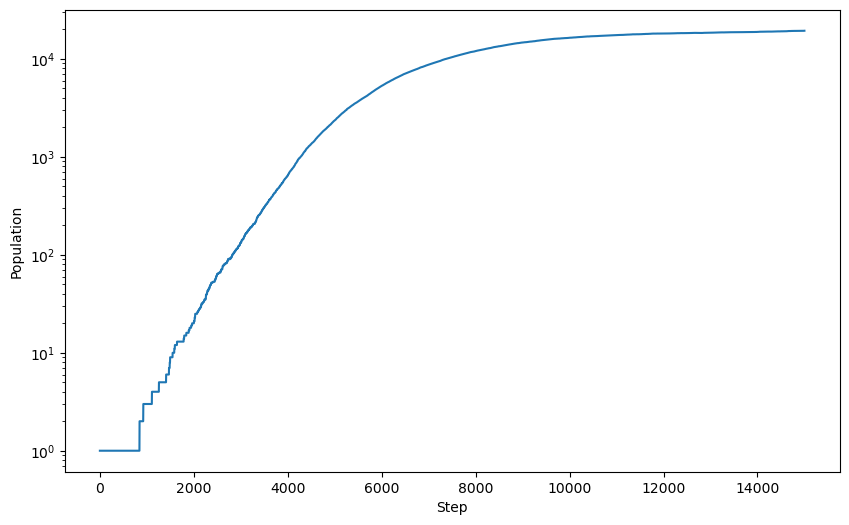

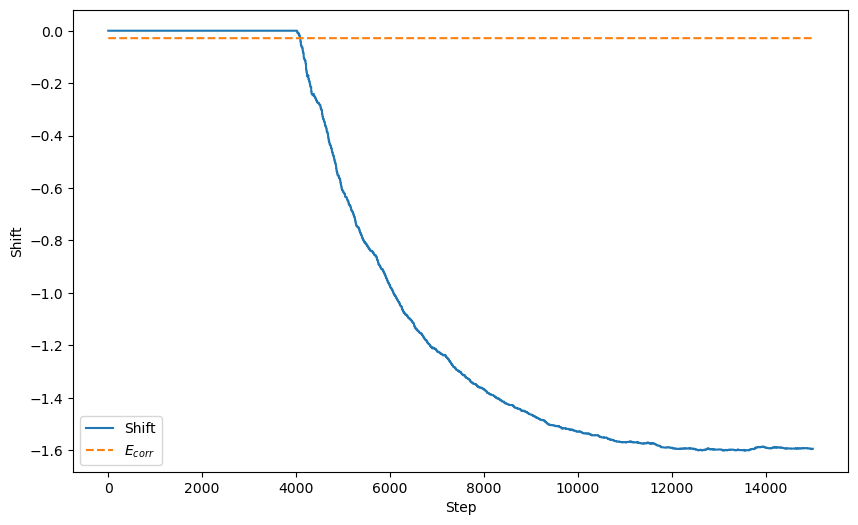

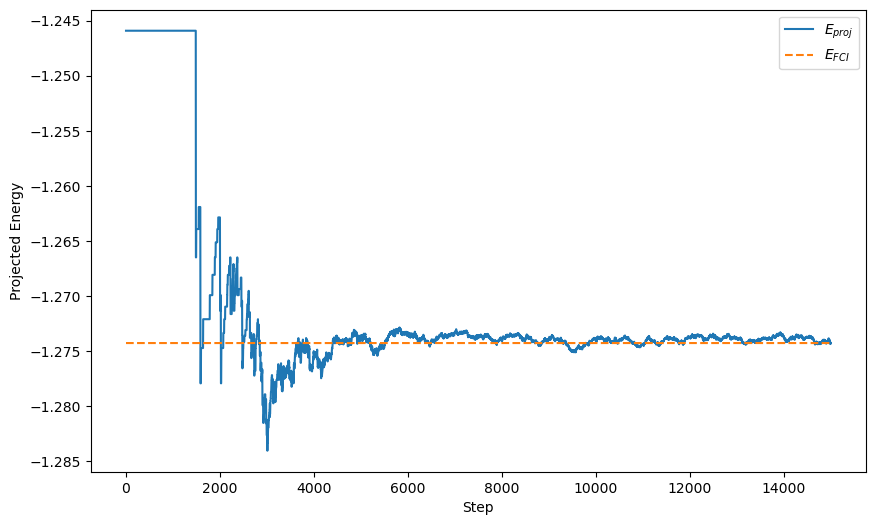

In [6]:
from pyscf import gto

# H3+分子の定義
mol = gto.M(
    atom = "H 0 0 0; H 1 0 0; H 0.5 0.866 0",
    basis = "sto-3g",
    charge = 1,
    spin = 0
)
E_est, E_fci, E_HF, hist_population, hist_shift, hist_energy = \
    FCIQMC(mol, n_steps=15000, n_prod=7000, step_starting_shift_upd=4000)

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"Final FCIQMC Energy: {E_est:.6f} Ha")
plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy)


## ${LiH}$ (STO-3G)
FCI行列は225x225

--- FCI Matrix ---
(225, 225)
[[-8.85407204  0.00000001 -0.         ...  0.          0.          0.        ]
 [ 0.00000001 -8.70113079 -0.01121134 ...  0.          0.          0.        ]
 [-0.         -0.01121134 -6.80106501 ...  0.          0.          0.        ]
 ...
 [ 0.          0.          0.         ... -2.45454152  0.         -0.        ]
 [ 0.          0.          0.         ...  0.         -2.40746928  0.        ]
 [ 0.          0.          0.         ... -0.          0.         -2.373731  ]]
--- K Matrix ---
[[-0.99220727  0.00000001 -0.         ...  0.          0.          0.        ]
 [ 0.00000001 -0.83926602 -0.01121134 ...  0.          0.          0.        ]
 [-0.         -0.01121134  1.06079976 ...  0.          0.          0.        ]
 ...
 [ 0.          0.          0.         ...  5.40732325  0.         -0.        ]
 [ 0.          0.          0.         ...  0.          5.45439549  0.        ]
 [ 0.          0.          0.         ... -0.          0.          5.4881

  0%|▎                                                                                             | 59/15000 [00:00<00:25, 589.34it/s]

Step 0: Walkers=1, Shift=0.00000, E_proj=-7.861865
  1 walkers on 0th determinant


  8%|███████▎                                                                                   | 1215/15000 [00:00<00:07, 1763.18it/s]

Step 1000: Walkers=7, Shift=0.00000, E_proj=-7.861865
  7 walkers on 0th determinant


 14%|█████████████▏                                                                              | 2148/15000 [00:02<00:14, 867.06it/s]

Step 2000: Walkers=24, Shift=0.00000, E_proj=-7.874135
  21 walkers on 0th determinant
  -1 walkers on 64th determinant
  -2 walkers on 160th determinant


 20%|██████████████████▊                                                                         | 3061/15000 [00:04<00:35, 335.18it/s]

Step 3000: Walkers=78, Shift=0.00000, E_proj=-7.885874
  60 walkers on 0th determinant
  -2 walkers on 48th determinant
  1 walkers on 63th determinant
  4 walkers on 151th determinant
  -10 walkers on 160th determinant
  -1 walkers on 176th determinant


 27%|████████████████████████▋                                                                   | 4020/15000 [00:09<01:35, 115.44it/s]

Step 4000: Walkers=199, Shift=-0.35468, E_proj=-7.882649
  141 walkers on 0th determinant
  4 walkers on 1th determinant
  1 walkers on 11th determinant
  -1 walkers on 16th determinant
  3 walkers on 25th determinant
  -2 walkers on 32th determinant
  -6 walkers on 48th determinant
  1 walkers on 49th determinant
  1 walkers on 63th determinant
  -3 walkers on 96th determinant
  1 walkers on 111th determinant
  16 walkers on 151th determinant
  1 walkers on 152th determinant
  -16 walkers on 160th determinant
  1 walkers on 175th determinant
  -1 walkers on 58th determinant


 33%|███████████████████████████████                                                              | 5017/15000 [00:17<01:44, 95.37it/s]

Step 5000: Walkers=324, Shift=-0.58914, E_proj=-7.886486
  218 walkers on 0th determinant
  9 walkers on 1th determinant
  1 walkers on 10th determinant
  1 walkers on 11th determinant
  10 walkers on 25th determinant
  -1 walkers on 31th determinant
  -7 walkers on 48th determinant
  2 walkers on 49th determinant
  1 walkers on 63th determinant
  -9 walkers on 96th determinant
  1 walkers on 97th determinant
  26 walkers on 151th determinant
  -1 walkers on 152th determinant
  -30 walkers on 160th determinant
  1 walkers on 127th determinant
  -1 walkers on 181th determinant
  1 walkers on 182th determinant
  -1 walkers on 58th determinant
  -1 walkers on 198th determinant
  1 walkers on 208th determinant
  1 walkers on 199th determinant


 40%|█████████████████████████████████████▎                                                       | 6011/15000 [00:26<01:30, 99.53it/s]

Step 6000: Walkers=458, Shift=-0.74112, E_proj=-7.884693
  317 walkers on 0th determinant
  12 walkers on 1th determinant
  1 walkers on 2th determinant
  2 walkers on 15th determinant
  -7 walkers on 16th determinant
  15 walkers on 25th determinant
  -1 walkers on 26th determinant
  -3 walkers on 32th determinant
  -1 walkers on 40th determinant
  -10 walkers on 48th determinant
  2 walkers on 49th determinant
  1 walkers on 63th determinant
  -10 walkers on 96th determinant
  1 walkers on 97th determinant
  2 walkers on 111th determinant
  28 walkers on 151th determinant
  -41 walkers on 160th determinant
  1 walkers on 175th determinant
  1 walkers on 65th determinant
  1 walkers on 191th determinant
  -1 walkers on 104th determinant


 47%|███████████████████████████████████████████▍                                                 | 7010/15000 [00:36<01:28, 89.87it/s]

Step 7000: Walkers=548, Shift=-0.80805, E_proj=-7.880362
  392 walkers on 0th determinant
  15 walkers on 1th determinant
  -1 walkers on 10th determinant
  6 walkers on 15th determinant
  -8 walkers on 16th determinant
  15 walkers on 25th determinant
  -3 walkers on 32th determinant
  -13 walkers on 48th determinant
  1 walkers on 63th determinant
  -1 walkers on 64th determinant
  -12 walkers on 96th determinant
  2 walkers on 111th determinant
  1 walkers on 150th determinant
  28 walkers on 151th determinant
  -1 walkers on 152th determinant
  -40 walkers on 160th determinant
  1 walkers on 166th determinant
  3 walkers on 175th determinant
  -2 walkers on 176th determinant
  1 walkers on 192th determinant
  1 walkers on 162th determinant
  -1 walkers on 126th determinant


 53%|█████████████████████████████████████████████████▌                                           | 8003/15000 [00:48<01:14, 94.38it/s]

Step 8000: Walkers=669, Shift=-0.83915, E_proj=-7.882130
  470 walkers on 0th determinant
  20 walkers on 1th determinant
  4 walkers on 10th determinant
  2 walkers on 12th determinant
  6 walkers on 15th determinant
  -15 walkers on 16th determinant
  17 walkers on 25th determinant
  -1 walkers on 32th determinant
  -13 walkers on 48th determinant
  4 walkers on 49th determinant
  -3 walkers on 64th determinant
  -19 walkers on 96th determinant
  3 walkers on 97th determinant
  -2 walkers on 112th determinant
  30 walkers on 151th determinant
  -55 walkers on 160th determinant
  1 walkers on 166th determinant
  -1 walkers on 176th determinant
  1 walkers on 180th determinant
  1 walkers on 208th determinant
  -1 walkers on 50th determinant


 60%|███████████████████████████████████████████████████████▉                                     | 9016/15000 [00:59<01:06, 90.30it/s]

Step 9000: Walkers=715, Shift=-0.97403, E_proj=-7.883498
  506 walkers on 0th determinant
  23 walkers on 1th determinant
  1 walkers on 10th determinant
  7 walkers on 15th determinant
  -17 walkers on 16th determinant
  23 walkers on 25th determinant
  -1 walkers on 26th determinant
  -1 walkers on 30th determinant
  2 walkers on 31th determinant
  -2 walkers on 32th determinant
  -12 walkers on 48th determinant
  2 walkers on 49th determinant
  -16 walkers on 96th determinant
  -2 walkers on 112th determinant
  2 walkers on 150th determinant
  26 walkers on 151th determinant
  -67 walkers on 160th determinant
  1 walkers on 166th determinant
  1 walkers on 176th determinant
  1 walkers on 127th determinant
  -1 walkers on 104th determinant
  1 walkers on 224th determinant


 67%|█████████████████████████████████████████████████████████████▍                              | 10015/15000 [01:11<00:57, 86.32it/s]

Step 10000: Walkers=785, Shift=-0.95264, E_proj=-7.884442
  536 walkers on 0th determinant
  30 walkers on 1th determinant
  7 walkers on 15th determinant
  -22 walkers on 16th determinant
  1 walkers on 17th determinant
  32 walkers on 25th determinant
  1 walkers on 31th determinant
  -3 walkers on 32th determinant
  -14 walkers on 48th determinant
  1 walkers on 49th determinant
  1 walkers on 63th determinant
  -2 walkers on 64th determinant
  -16 walkers on 96th determinant
  -2 walkers on 112th determinant
  1 walkers on 150th determinant
  42 walkers on 151th determinant
  1 walkers on 152th determinant
  -68 walkers on 160th determinant
  1 walkers on 161th determinant
  2 walkers on 166th determinant
  1 walkers on 192th determinant
  -1 walkers on 162th determinant


 73%|███████████████████████████████████████████████████████████████████▌                        | 11008/15000 [01:21<00:53, 74.75it/s]

Step 11000: Walkers=855, Shift=-0.93995, E_proj=-7.886064
  575 walkers on 0th determinant
  30 walkers on 1th determinant
  -1 walkers on 2th determinant
  -1 walkers on 10th determinant
  13 walkers on 15th determinant
  -21 walkers on 16th determinant
  -1 walkers on 17th determinant
  33 walkers on 25th determinant
  3 walkers on 26th determinant
  1 walkers on 40th determinant
  -16 walkers on 48th determinant
  3 walkers on 49th determinant
  2 walkers on 63th determinant
  -18 walkers on 96th determinant
  2 walkers on 97th determinant
  1 walkers on 111th determinant
  -1 walkers on 112th determinant
  4 walkers on 150th determinant
  39 walkers on 151th determinant
  -83 walkers on 160th determinant
  1 walkers on 176th determinant
  -1 walkers on 27th determinant
  1 walkers on 80th determinant
  -2 walkers on 182th determinant
  1 walkers on 88th determinant
  -1 walkers on 50th determinant


 80%|█████████████████████████████████████████████████████████████████████████▋                  | 12007/15000 [01:35<00:45, 65.75it/s]

Step 12000: Walkers=905, Shift=-0.96780, E_proj=-7.883918
  620 walkers on 0th determinant
  32 walkers on 1th determinant
  2 walkers on 10th determinant
  1 walkers on 11th determinant
  1 walkers on 12th determinant
  16 walkers on 15th determinant
  -13 walkers on 16th determinant
  38 walkers on 25th determinant
  -1 walkers on 30th determinant
  1 walkers on 31th determinant
  -1 walkers on 32th determinant
  -11 walkers on 48th determinant
  3 walkers on 49th determinant
  3 walkers on 63th determinant
  -3 walkers on 64th determinant
  -16 walkers on 96th determinant
  2 walkers on 97th determinant
  -1 walkers on 112th determinant
  5 walkers on 150th determinant
  43 walkers on 151th determinant
  1 walkers on 152th determinant
  -80 walkers on 160th determinant
  2 walkers on 166th determinant
  1 walkers on 167th determinant
  1 walkers on 175th determinant
  -3 walkers on 176th determinant
  -1 walkers on 42th determinant
  -1 walkers on 191th determinant
  -2 walkers on 2

 87%|███████████████████████████████████████████████████████████████████████████████▊            | 13005/15000 [01:49<00:27, 71.40it/s]

Step 13000: Walkers=911, Shift=-1.02870, E_proj=-7.880470
  625 walkers on 0th determinant
  33 walkers on 1th determinant
  -1 walkers on 2th determinant
  2 walkers on 10th determinant
  1 walkers on 11th determinant
  24 walkers on 15th determinant
  -18 walkers on 16th determinant
  44 walkers on 25th determinant
  1 walkers on 26th determinant
  1 walkers on 31th determinant
  -5 walkers on 32th determinant
  -14 walkers on 48th determinant
  1 walkers on 49th determinant
  3 walkers on 63th determinant
  -14 walkers on 96th determinant
  2 walkers on 97th determinant
  3 walkers on 111th determinant
  -1 walkers on 112th determinant
  5 walkers on 150th determinant
  46 walkers on 151th determinant
  -60 walkers on 160th determinant
  1 walkers on 165th determinant
  1 walkers on 166th determinant
  -1 walkers on 167th determinant
  -1 walkers on 175th determinant
  1 walkers on 180th determinant
  -1 walkers on 104th determinant
  -1 walkers on 190th determinant


 93%|█████████████████████████████████████████████████████████████████████████████████████▉      | 14010/15000 [02:03<00:19, 51.85it/s]

Step 14000: Walkers=931, Shift=-0.99052, E_proj=-7.881734
  633 walkers on 0th determinant
  30 walkers on 1th determinant
  -1 walkers on 2th determinant
  25 walkers on 15th determinant
  -15 walkers on 16th determinant
  1 walkers on 17th determinant
  47 walkers on 25th determinant
  2 walkers on 26th determinant
  1 walkers on 30th determinant
  -3 walkers on 32th determinant
  1 walkers on 40th determinant
  -16 walkers on 48th determinant
  2 walkers on 49th determinant
  3 walkers on 63th determinant
  -4 walkers on 64th determinant
  -16 walkers on 96th determinant
  3 walkers on 97th determinant
  1 walkers on 111th determinant
  -2 walkers on 112th determinant
  4 walkers on 150th determinant
  36 walkers on 151th determinant
  -1 walkers on 152th determinant
  -69 walkers on 160th determinant
  2 walkers on 166th determinant
  1 walkers on 167th determinant
  -1 walkers on 176th determinant
  1 walkers on 27th determinant
  -1 walkers on 177th determinant
  -1 walkers on 18

100%|███████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [02:19<00:00, 107.40it/s]



---- Walkers (result) ----
657 walkers on 0th determinant
31 walkers on 1th determinant
1 walkers on 2th determinant
1 walkers on 10th determinant
30 walkers on 15th determinant
-13 walkers on 16th determinant
1 walkers on 17th determinant
56 walkers on 25th determinant
-1 walkers on 31th determinant
-2 walkers on 32th determinant
2 walkers on 40th determinant
-21 walkers on 48th determinant
1 walkers on 63th determinant
-1 walkers on 64th determinant
-22 walkers on 96th determinant
3 walkers on 111th determinant
1 walkers on 150th determinant
33 walkers on 151th determinant
-1 walkers on 152th determinant
-85 walkers on 160th determinant
1 walkers on 165th determinant
1 walkers on 166th determinant
1 walkers on 180th determinant
-1 walkers on 27th determinant
-1 walkers on 42th determinant
-1 walkers on 79th determinant
1 walkers on 127th determinant
-1 walkers on 177th determinant
1 walkers on 182th determinant
1 walkers on 192th determinant
-2 walkers on 58th determinant
-3 walkers

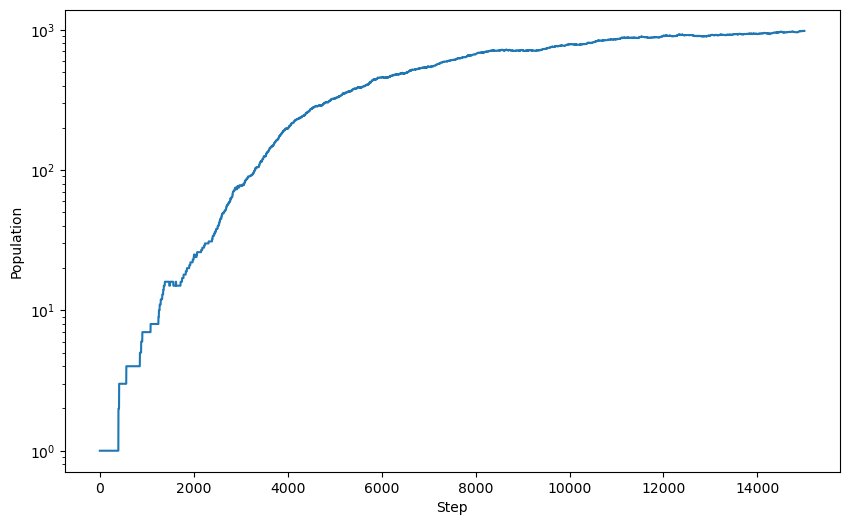

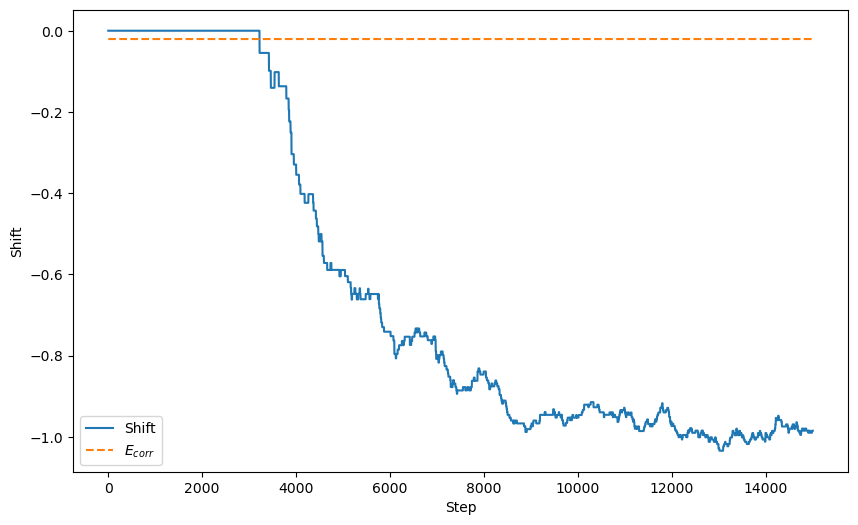

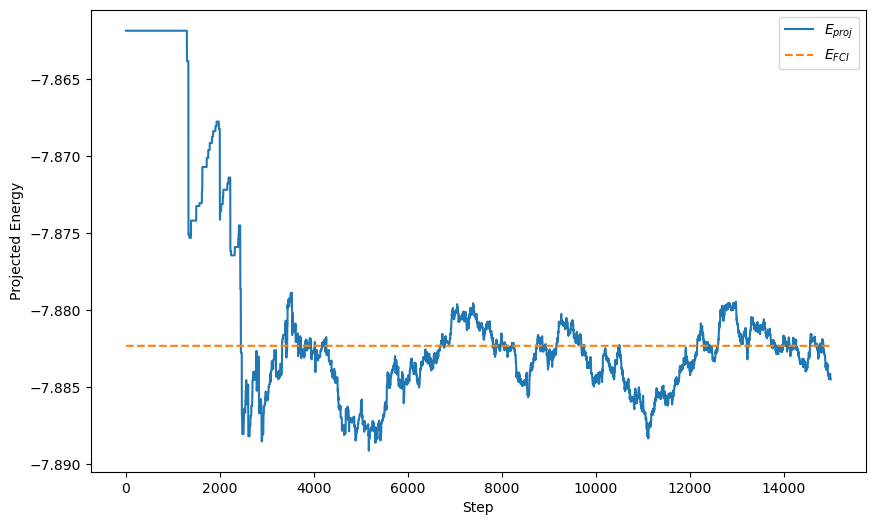

In [228]:
from pyscf import gto

# LiH分子の定義
mol = gto.M(
    atom=f"Li 0 0 0; H 0 0 1.6",
    basis="sto-3g",
    spin=0,      # singlet
    verbose=0
)
E_est, E_fci, E_HF, hist_population, hist_shift, hist_energy = \
    FCIQMC(mol, n_steps=15000, n_prod=5000, step_starting_shift_upd=3000)

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"Final FCIQMC Energy: {E_est:.6f} Ha")
plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy)


## ${N_2}$ at equilibrium
FCI行列が巨大過ぎて生成出来ない。必要な成分のみ取ってくる実装（on the fly?）に変える必要がありそう

In [ ]:
from pyscf import gto

# N2 at equilibriumの定義
R_bohr = 2.068     # a0
R_ang = R_bohr * 0.529177

mol = gto.M(
    atom=f"N 0 0 0; N 0 0 {R_ang}",
    basis="cc-pVDZ",
    unit="Angstrom",
    spin=0,      # singlet
    verbose=0
)
E_est, E_fci, E_HF, hist_population, hist_shift, hist_energy = \
    FCIQMC(mol, n_steps=1000, n_prod=500, step_starting_shift_upd=100)

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"Final FCIQMC Energy: {E_est:.6f} Ha")
plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy)
